# Background


This notebook is to make a baseline for slot1, aspect category detection. We use glove to generate sentence vector. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import anago
from anago.utils import load_data_and_labels, load_glove

Using TensorFlow backend.


In [3]:
ls ../datasets/

raw-semeval-2016/ restaurant2.zip   semeval-2016/
restaurant/       restaurant_small/


In [4]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/train.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/test.csv')

In [5]:
# Read data
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [6]:
def df2data(df):
    """Read data and labels from dataframe
    Input:
        df: three columns, ['Sentence #', 'Tag', 'Word']
    Output:
        data: datasize * ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
        label: datasize * ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
    """
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["Tag"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    data = [[w[0] for w in s] for s in grouped]
    label = [[w[1] for w in s] for s in grouped]  
    
    return data, label

In [7]:
x_train_words, _ = df2data(data_train)
x_test_words, _ = df2data(data_test)

### embedding

In [11]:
EMBEDDING_PATH = '../embedding_weights/glove.840B.300d.txt'

In [12]:
embeddings = load_glove(EMBEDDING_PATH)

No need to padding

In [13]:
def word2vector(x_words):

    sentence_vectors = []

    for sent in x_words:
        one_sentence = [0]*300
        for word in sent:
            if not embeddings.get(word) is None:
                one_sentence += embeddings[word]
        sentence_vectors.append(one_sentence)
    return np.array(sentence_vectors)

In [14]:
x_train = word2vector(x_train_words)
x_test = word2vector(x_test_words)

In [15]:
print(len(x_train))
print(len(x_test))
print(type(x_train))
print(type(x_train[0]))

2000
676
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


add attention feature 

In [16]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/train_att_sentence.npy')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/test_att_sentence.npy')

In [17]:
att_train_feature = np.load(train_path)
att_test_feature = np.load(test_path)

In [18]:
att_train_feature.shape

(2000, 200)

In [19]:
x_train.shape

(2000, 300)

In [30]:
x_train = np.concatenate((x_train, att_train_feature), axis=1)
x_test = np.concatenate((x_test, att_test_feature), axis=1)
print(x_train.shape)
print(x_test.shape)

(2000, 500)
(676, 500)


normalize the data 

In [21]:
from sklearn import preprocessing

In [22]:
scaler = preprocessing.StandardScaler().fit(x_train)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
scaler.transform(x_train)

array([[-0.73575327,  0.52554607, -1.08199402, ..., -1.07554505,
        -1.08445977,  0.88927701],
       [-0.58087701,  2.36753643, -1.8801042 , ...,  0.92336322,
         1.39767802, -1.16058099],
       [-2.09565181,  0.30195656, -0.35252755, ..., -0.28339354,
        -0.10923064,  0.60763584],
       ...,
       [ 1.50312929,  1.94025992, -1.61259435, ...,  0.97949915,
        -0.64245431, -0.927687  ],
       [ 0.81004495,  0.85649514, -3.05478256, ..., -0.4421231 ,
         1.25403495, -0.78690922],
       [ 0.44834762,  1.00423237, -1.72283029, ...,  0.5594729 ,
         0.62216571,  2.27981089]])

In [26]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### label 

this is a multicalss classification

In [27]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/train_label_df.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/test_label_df.csv')

In [28]:
y_train_df = pd.read_csv(train_path)
y_test_df = pd.read_csv(test_path)

In [29]:
y_train_df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [30]:
y_train = y_train_df.values
y_test = y_test_df.values

# model construct

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

ovr = OneVsRestClassifier(LogisticRegression())

(2000, 300)
(2000, 12)
[learning_curve] Training set sizes: [ 160  520  880 1240 1600]
[CV]  ................................................................
[CV] ................................... , score=0.4025, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................... , score=0.4325, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ..................................... , score=0.45, total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV] .................................... , score=0.475, total=   1.8s
[CV]  ................................................................
[CV] ................................... , score=0.4625, total=   2.4s
[CV]  ................................................................
[CV] .................................... , score=0.265, total=   0.1s
[CV]  ................................................................
[CV] ..................................... , score=0.37, total=   0.6s
[CV]  ................................................................
[CV] ................................... , score=0.3575, total=   1.1s
[CV]  ................................................................
[CV] .................................... , score=0.355, total=   1.8s
[CV]  ................................................................
[CV] ..................................... , score=0.41, total=   2.4s
[CV]  ................................................................
[CV] .

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))


[CV] ................................... , score=0.3625, total=   0.6s
[CV]  ................................................................
[CV] ................................... , score=0.4075, total=   1.1s
[CV]  ................................................................
[CV] ................................... , score=0.4275, total=   1.7s
[CV]  ................................................................
[CV] .................................... , score=0.445, total=   2.6s
[CV]  ................................................................
[CV] .................................... , score=0.255, total=   0.1s
[CV]  ................................................................
[CV] ................................... , score=0.3625, total=   0.6s
[CV]  ................................................................
[CV] .................................... , score=0.365, total=   1.1s
[CV]  ................................................................
[CV] .

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


[CV] ................................... , score=0.3125, total=   0.6s
[CV]  ................................................................
[CV] ................................... , score=0.3475, total=   1.0s
[CV]  ................................................................
[CV] ................................... , score=0.3975, total=   1.7s
[CV]  ................................................................
[CV] ................................... , score=0.3825, total=   2.5s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   30.3s finished


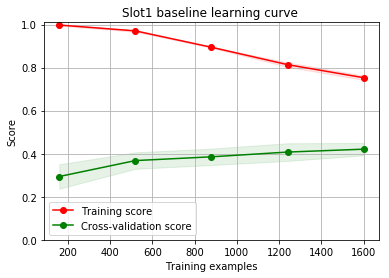

In [32]:
# first to see the cv result 
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


%matplotlib inline

# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
ovr = OneVsRestClassifier(LogisticRegression())

X = x_train
train_labels = y_train
print(X.shape)
print(train_labels.shape)
plot_learning_curve(ovr, "Slot1 baseline learning curve ",
                    X, train_labels, ylim=(0.0, 1.01), cv=cv, n_jobs=1, verbose=4)

plt.show()

In [33]:
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

def loop_predict(model, x_train, x_test, y_train, y_test, loop=5):
    f1 = []
    for i in range(loop):
        x_train, x_test = shuffle(x_train, x_test)
        model.fit(x_train, x_test)
        y_pred = model.predict(y_train)
        micro_f1 = f1_score(y_test, y_pred, average='micro')
        f1.append(micro_f1)
    print("F1 is {} (+/-{})".format(np.mean(f1), np.std(f1)))
    return model

In [34]:
train_x = x_train
train_labels = y_train
test_x = x_test
test_labels = y_test

In [35]:
ovr = OneVsRestClassifier(LogisticRegression())

model1 = loop_predict(ovr, train_x, train_labels, test_x, test_labels)

F1 is 0.5894172806430007 (+/-0.0)


no StandardScaler: f1 : 0.5727
with standardScaler: f1: 0.589